In [87]:
# import necessary packeges
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper

from collections import OrderedDict

from sklearn.model_selection import cross_val_score, train_test_split

from torch.utils.data.sampler import SubsetRandomSampler

import time

Get the device. Device is either cuda:0 or cpu

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [89]:
# define a trandform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

# download the training data
trainset = datasets.FashionMNIST('F_MNIST_data', train=True, download=True, transform=transform)

# download the testing data
testset = datasets.FashionMNIST('F_MNIST_data', train=False, download=True, transform=transform)

print(trainset)
print(testset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: F_MNIST_data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: F_MNIST_data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


Devide the training set into a training and a validation set!

In [90]:
shuffle_dataset = True
validation_split = .2
random_seed= 42

trainset_size = len(trainset)
indices = list(range(trainset_size))
split = int(np.floor(validation_split * trainset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
print(len(train_indices))
print(len(val_indices))

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


48000
12000


In [91]:
train_loader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
validation_loader = DataLoader(trainset, batch_size=64, sampler=valid_sampler)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

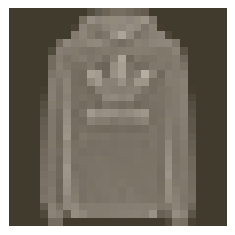

In [92]:
images, labels = next(iter(train_loader))
helper.imshow(images[0,:]);

In [93]:
images.size()

torch.Size([64, 1, 28, 28])

In [94]:
labels.size()

torch.Size([64])

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits from the forward pass. It's up to you how many layers you add and the size of those layers.

There are two possible ways to build a network: 1. a static one 2. a dynamic one. 
<br>

The dynamic one allows us to configure as many hidden layers as we want just by modifying a patrameter list of the hidden layers. This is done with the help of [`nn.ModuleList`](https://pytorch.org/docs/stable/nn.html#modulelist).

In [95]:
class Network(nn.Module):
    def __init__(self, input_layer_size, output_layer_size, hidden_layers, drop_p = 0.5):
        ''' build a feedforward network with arbitraty many hidden layers
        
            Arguments
            ---------
            input_layer: integer, size of the input
            hidden_layers: list of integers, amount and size of the hidden layers
            output_layer: integer, size of the output layer
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # add the first layer input to hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_layer_size, hidden_layers[0])])
        
        # add a viariable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_layer_size)
        
        self.dropout = nn.Dropout(p = drop_p)
        
    def forward(self,x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in the hidden_layers, with ReLU activation and dropouts
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
            
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)
                

In [96]:
input_layer = 784
hidden_layers = [800, 600, 400, 200]
output_layer = 10

netmodel = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(input_layer, hidden_layers[0])),
    ('relu1', nn.ReLU()),
    ('fcl2', nn.Linear(hidden_layers[0], hidden_layers[0])),
    ('relu2', nn.ReLU()),
    ('fcl3', nn.Linear(hidden_layers[0], hidden_layers[1])),
    ('relu3', nn.ReLU()),
    ('fcl4', nn.Linear(hidden_layers[1], hidden_layers[1])),
    ('relu4', nn.ReLU()),
    ('fcl5', nn.Linear(hidden_layers[1], hidden_layers[2])),
    ('relu5', nn.ReLU()),
    ('fcl6', nn.Linear(hidden_layers[2], hidden_layers[2])),
    ('relu6', nn.ReLU()),
    ('fcl7', nn.Linear(hidden_layers[2], hidden_layers[3])),
    ('relu7', nn.ReLU()),
    ('fcl8', nn.Linear(hidden_layers[3], hidden_layers[3])),
    ('relu8', nn.ReLU()),
    ('output', nn.Linear(hidden_layers[3], output_layer))
]))

netmodel

Sequential(
  (fcl1): Linear(in_features=784, out_features=800, bias=True)
  (relu1): ReLU()
  (fcl2): Linear(in_features=800, out_features=800, bias=True)
  (relu2): ReLU()
  (fcl3): Linear(in_features=800, out_features=600, bias=True)
  (relu3): ReLU()
  (fcl4): Linear(in_features=600, out_features=600, bias=True)
  (relu4): ReLU()
  (fcl5): Linear(in_features=600, out_features=400, bias=True)
  (relu5): ReLU()
  (fcl6): Linear(in_features=400, out_features=400, bias=True)
  (relu6): ReLU()
  (fcl7): Linear(in_features=400, out_features=200, bias=True)
  (relu7): ReLU()
  (fcl8): Linear(in_features=200, out_features=200, bias=True)
  (relu8): ReLU()
  (output): Linear(in_features=200, out_features=10, bias=True)
)

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

Select the network - dynamic or static

In [97]:
nnDynamic = True

In [98]:
if nnDynamic == False:
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(netmodel.parameters(), lr=0.001)
    optimizer = optim.Adam(netmodel.parameters(), lr=0.0003)
    #optimizer = optim.SGD(netmodel.parameters(), lr=0.003)

In [100]:
if nnDynamic == True:
    input_layer_size = 784
    output_layer_size = 10
    #hidden_layers_list = [512, 256, 128, 64]
    hidden_layers_list = [800, 800, 600, 600, 400, 400, 200, 200]
    dropout_p = 0.0
    netmodel = Network(input_layer_size, output_layer_size, hidden_layers_list, dropout_p)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(netmodel.parameters(), lr=0.003)

netmodel

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=800, bias=True)
    (1): Linear(in_features=800, out_features=800, bias=True)
    (2): Linear(in_features=800, out_features=600, bias=True)
    (3): Linear(in_features=600, out_features=600, bias=True)
    (4): Linear(in_features=600, out_features=400, bias=True)
    (5): Linear(in_features=400, out_features=400, bias=True)
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): Linear(in_features=200, out_features=200, bias=True)
  )
  (output): Linear(in_features=200, out_features=10, bias=True)
  (dropout): Dropout(p=0.0)
)

In [101]:
epochs = 30
steps = 0
running_loss = 0
print_every = 40

netmodel.to(device)

start = time.time()

for e in range(epochs):
    running_loss = 0
    for images, labels in iter(train_loader):
        steps += 1
        
        # flatten the imiga into a 784 element vector
        images.resize_(images.size()[0], 784)
        
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        output = netmodel.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            netmodel.eval()
        
            accuracy = 0
            valid_loss = 0
            
            for ii, (images, labels) in enumerate(validation_loader):
                
                
                # flatten the imiga into a 784 element vector
                images.resize_(images.size()[0], 784)
                
                with torch.no_grad():
                    images, labels = images.to(device), labels.to(device)

                output = netmodel.forward(images)
                valid_loss += criterion(output, labels).item()
                
                if nnDynamic == True:
                    ps = torch.exp(output)
                else:
                    ps = F.softmax(output, dim=1)
                
                
                equality = (labels.data == ps.max(1)[1])
                
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(validation_loader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)))
            
            running_loss = 0
            
            # Make sure dropout is on for training
            netmodel.train()
            
print("Time for training and validation : {:.0f} minutes and {:.3f} seconds".format((time.time() - start)/60, (time.time() - start) % 60))

Epoch: 1/30...  Loss: 1.9129 Validation Loss: 1.538..  Validation Accuracy: 0.219
Epoch: 1/30...  Loss: 1.4744 Validation Loss: 1.373..  Validation Accuracy: 0.441
Epoch: 1/30...  Loss: 1.4217 Validation Loss: 1.265..  Validation Accuracy: 0.578
Epoch: 1/30...  Loss: 1.1416 Validation Loss: 1.020..  Validation Accuracy: 0.536
Epoch: 1/30...  Loss: 1.0347 Validation Loss: 0.948..  Validation Accuracy: 0.625
Epoch: 1/30...  Loss: 1.0097 Validation Loss: 0.941..  Validation Accuracy: 0.595
Epoch: 1/30...  Loss: 0.8715 Validation Loss: 0.870..  Validation Accuracy: 0.684
Epoch: 1/30...  Loss: 0.8799 Validation Loss: 1.169..  Validation Accuracy: 0.498
Epoch: 1/30...  Loss: 0.9519 Validation Loss: 0.857..  Validation Accuracy: 0.665
Epoch: 1/30...  Loss: 0.8160 Validation Loss: 0.831..  Validation Accuracy: 0.685
Epoch: 1/30...  Loss: 0.7965 Validation Loss: 0.843..  Validation Accuracy: 0.708
Epoch: 1/30...  Loss: 0.7523 Validation Loss: 0.702..  Validation Accuracy: 0.748
Epoch: 1/30...  

Epoch: 6/30...  Loss: 0.3921 Validation Loss: 0.465..  Validation Accuracy: 0.843
Epoch: 6/30...  Loss: 0.4278 Validation Loss: 0.435..  Validation Accuracy: 0.847
Epoch: 6/30...  Loss: 0.3871 Validation Loss: 0.455..  Validation Accuracy: 0.845
Epoch: 6/30...  Loss: 0.3850 Validation Loss: 0.432..  Validation Accuracy: 0.847
Epoch: 6/30...  Loss: 0.3804 Validation Loss: 0.417..  Validation Accuracy: 0.854
Epoch: 6/30...  Loss: 0.3985 Validation Loss: 0.420..  Validation Accuracy: 0.853
Epoch: 6/30...  Loss: 0.3741 Validation Loss: 0.419..  Validation Accuracy: 0.853
Epoch: 6/30...  Loss: 0.4031 Validation Loss: 0.393..  Validation Accuracy: 0.865
Epoch: 6/30...  Loss: 0.3730 Validation Loss: 0.419..  Validation Accuracy: 0.852
Epoch: 6/30...  Loss: 0.3963 Validation Loss: 0.438..  Validation Accuracy: 0.839
Epoch: 6/30...  Loss: 0.4108 Validation Loss: 0.432..  Validation Accuracy: 0.846
Epoch: 6/30...  Loss: 0.3825 Validation Loss: 0.408..  Validation Accuracy: 0.856
Epoch: 7/30...  

Epoch: 11/30...  Loss: 0.3226 Validation Loss: 0.409..  Validation Accuracy: 0.860
Epoch: 11/30...  Loss: 0.3646 Validation Loss: 0.381..  Validation Accuracy: 0.870
Epoch: 11/30...  Loss: 0.3293 Validation Loss: 0.372..  Validation Accuracy: 0.871
Epoch: 11/30...  Loss: 0.3436 Validation Loss: 0.396..  Validation Accuracy: 0.867
Epoch: 11/30...  Loss: 0.3303 Validation Loss: 0.382..  Validation Accuracy: 0.872
Epoch: 11/30...  Loss: 0.3290 Validation Loss: 0.379..  Validation Accuracy: 0.873
Epoch: 12/30...  Loss: 0.2313 Validation Loss: 0.384..  Validation Accuracy: 0.873
Epoch: 12/30...  Loss: 0.3887 Validation Loss: 0.422..  Validation Accuracy: 0.858
Epoch: 12/30...  Loss: 0.3454 Validation Loss: 0.388..  Validation Accuracy: 0.868
Epoch: 12/30...  Loss: 0.3389 Validation Loss: 0.395..  Validation Accuracy: 0.861
Epoch: 12/30...  Loss: 0.3492 Validation Loss: 0.377..  Validation Accuracy: 0.867
Epoch: 12/30...  Loss: 0.3211 Validation Loss: 0.388..  Validation Accuracy: 0.869
Epoc

Epoch: 16/30...  Loss: 0.3434 Validation Loss: 0.394..  Validation Accuracy: 0.865
Epoch: 17/30...  Loss: 0.3357 Validation Loss: 0.355..  Validation Accuracy: 0.877
Epoch: 17/30...  Loss: 0.3213 Validation Loss: 0.391..  Validation Accuracy: 0.872
Epoch: 17/30...  Loss: 0.2826 Validation Loss: 0.368..  Validation Accuracy: 0.877
Epoch: 17/30...  Loss: 0.2794 Validation Loss: 0.401..  Validation Accuracy: 0.873
Epoch: 17/30...  Loss: 0.3153 Validation Loss: 0.356..  Validation Accuracy: 0.879
Epoch: 17/30...  Loss: 0.2934 Validation Loss: 0.423..  Validation Accuracy: 0.876
Epoch: 17/30...  Loss: 0.3357 Validation Loss: 0.353..  Validation Accuracy: 0.885
Epoch: 17/30...  Loss: 0.2997 Validation Loss: 0.395..  Validation Accuracy: 0.870
Epoch: 17/30...  Loss: 0.3128 Validation Loss: 0.430..  Validation Accuracy: 0.855
Epoch: 17/30...  Loss: 0.3200 Validation Loss: 0.440..  Validation Accuracy: 0.868
Epoch: 17/30...  Loss: 0.3248 Validation Loss: 0.395..  Validation Accuracy: 0.872
Epoc

Epoch: 22/30...  Loss: 0.2542 Validation Loss: 0.377..  Validation Accuracy: 0.883
Epoch: 22/30...  Loss: 0.2860 Validation Loss: 0.378..  Validation Accuracy: 0.876
Epoch: 22/30...  Loss: 0.2695 Validation Loss: 0.365..  Validation Accuracy: 0.885
Epoch: 22/30...  Loss: 0.2630 Validation Loss: 0.366..  Validation Accuracy: 0.879
Epoch: 22/30...  Loss: 0.2757 Validation Loss: 0.382..  Validation Accuracy: 0.883
Epoch: 22/30...  Loss: 0.2485 Validation Loss: 0.416..  Validation Accuracy: 0.880
Epoch: 22/30...  Loss: 0.3140 Validation Loss: 0.433..  Validation Accuracy: 0.873
Epoch: 22/30...  Loss: 0.2837 Validation Loss: 0.400..  Validation Accuracy: 0.874
Epoch: 22/30...  Loss: 0.3066 Validation Loss: 0.451..  Validation Accuracy: 0.858
Epoch: 22/30...  Loss: 0.2990 Validation Loss: 0.442..  Validation Accuracy: 0.868
Epoch: 22/30...  Loss: 0.2806 Validation Loss: 0.410..  Validation Accuracy: 0.877
Epoch: 22/30...  Loss: 0.3061 Validation Loss: 0.410..  Validation Accuracy: 0.867
Epoc

Epoch: 27/30...  Loss: 0.3081 Validation Loss: 0.421..  Validation Accuracy: 0.873
Epoch: 27/30...  Loss: 0.2806 Validation Loss: 0.635..  Validation Accuracy: 0.876
Epoch: 27/30...  Loss: 0.2895 Validation Loss: 0.439..  Validation Accuracy: 0.881
Epoch: 27/30...  Loss: 0.2653 Validation Loss: 0.505..  Validation Accuracy: 0.877
Epoch: 27/30...  Loss: 0.2815 Validation Loss: 0.462..  Validation Accuracy: 0.879
Epoch: 27/30...  Loss: 0.2551 Validation Loss: 0.442..  Validation Accuracy: 0.885
Epoch: 27/30...  Loss: 0.2490 Validation Loss: 0.361..  Validation Accuracy: 0.885
Epoch: 27/30...  Loss: 0.2367 Validation Loss: 0.420..  Validation Accuracy: 0.884
Epoch: 27/30...  Loss: 0.2481 Validation Loss: 0.382..  Validation Accuracy: 0.888
Epoch: 28/30...  Loss: 0.1987 Validation Loss: 0.405..  Validation Accuracy: 0.883
Epoch: 28/30...  Loss: 0.2927 Validation Loss: 0.499..  Validation Accuracy: 0.874
Epoch: 28/30...  Loss: 0.2848 Validation Loss: 0.436..  Validation Accuracy: 0.882
Epoc

In [102]:
netmodel.eval()

netmodel.to(device)
        
accuracy = 0
test_loss = 0

for ii, (images, labels) in enumerate(test_loader):


    # flatten the imiga into a 784 element vector
    images.resize_(images.size()[0], 784)

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)

    output = netmodel.forward(images)

    if nnDynamic == True:
        ps = torch.exp(output)
    else:
        ps = F.softmax(output, dim=1)
    

    equality = (labels.data == ps.max(1)[1])

    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

running_loss = 0

Test Accuracy: 0.872


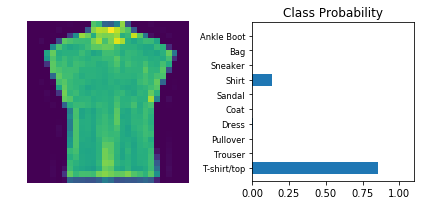

In [103]:
# Test out your network!
netmodel.to(device)

netmodel.eval()

dataiter = iter(test_loader)
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device)

img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    output = netmodel.forward(img)

if nnDynamic == True:
    ps = torch.exp(output)
else:
    ps = F.softmax(logits, dim=1)

#print(ps.size())
#print(ps.max(1)[1])

#print(ps.device, img.device)
if device != 'cpu':
    ps = ps.cpu()
    img = img.cpu()
#print(ps.device, img.device)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')